# Projeto Final - IA006 Machine Learning



    Alunos: Fernanda Ferreira RA:163676

            Renan Brotto RA:137442
        
        
Professores: Levy Boccato e Romis Attux

Data: 01/07/2019

## Open-set de Imagens Utilizando Redes Siamesas

In [99]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv1D
%matplotlib inline
import matplotlib.pyplot as plt

#num_classes = 3
epochs = 5


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

#def create_base_network(input_shape):
#    
#    Model=Sequential()
#    Model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#    Model.add(MaxPooling2D(pool_size=(2, 2)))
#    Model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
#    Model.add(MaxPooling2D(pool_size=(2, 2)))
#    Model.add(Flatten())
    #Model.add(Dense(100, activation='relu')) #200
    # Output Layer
    #Model.add(Dense(1, activation='softmax'))
    #Model.summary()
#    return Model

#def create_pairs(x, digit_indices, num_classes):
#    '''Positive and negative pair creation.
#    Alternates between positive and negative pairs.
#    '''
#    pairs = []
#    labels = []
#    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
#    for d in range(num_classes):
#        for i in range(n):
#            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
#            pairs += [[x[z1], x[z2]]]
#            inc = random.randrange(1, num_classes)
#            dn = (d + inc) % num_classes
#            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
#            pairs += [[x[z1], x[z2]]]
#            labels += [0, 1]
#    return np.array(pairs), np.array(labels)


def create_pairs(x, y, digit_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    y_pairs = []
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            y_pairs += [[y[z1], y[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            y_pairs += [[y[z1], y[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(y_pairs), np.array(labels)

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    #x = Dense(128, activation='relu')(x)
    #x = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

### Dataset utilizado: Mnist

In [86]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
print (input_shape)

(28, 28)


### Criação de pares aleatoriamente para a entrada da rede

In [100]:
num_classes2 = 3
digit_indices = [np.where(y_train == i)[0] for i in range(6)]
tr_pairs, try_pairs, tr_y = create_pairs(x_train, y_train, digit_indices, 6)



In [101]:
digit_indices2 = [np.where(y_test == i)[0] for i in range(8)]
te_pairs, tey_pairs, te_y = create_pairs(x_test, y_test, digit_indices2, 8)


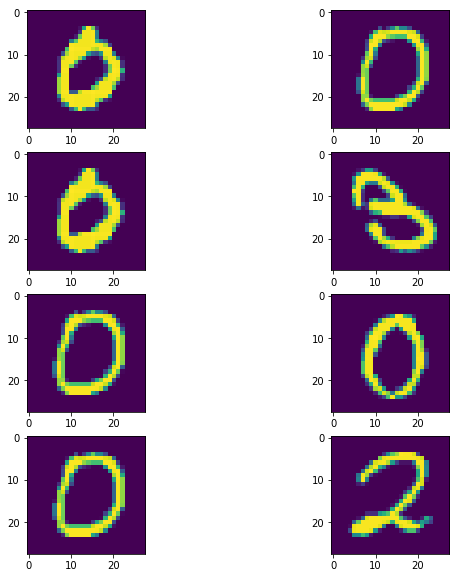

[0 0] [0 3] [0 0] [0 2]
[1 0 1 0]


In [193]:
fig, ax = plt.subplots(4, 2, figsize=(10,10))

ax[0][0].imshow(te_pairs[0][0])
ax[0][1].imshow(te_pairs[0][1])
ax[1][0].imshow(te_pairs[1][0])
ax[1][1].imshow(te_pairs[1][1])
ax[2][0].imshow(te_pairs[2][0])
ax[2][1].imshow(te_pairs[2][1])
ax[3][0].imshow(te_pairs[3][0])
ax[3][1].imshow(te_pairs[3][1])
plt.show()

print (tey_pairs[0], tey_pairs[1], tey_pairs[2], tey_pairs[3])
print (te_y[0:4])

Quando os pares são iguais, são rotulados como 1 e quando os pares são diferentes são rotulados como 0.

In [103]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [104]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_9 (Model)                 (None, 32)           26176       input_14[0][0]                   
                                                                 input_15[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 1)            0           model_9[1][0]                    
          

### O modelo da rede foi obtido utilizando os dados de treinamento e os dados de teste como validação para ajuste dos parâmetros da função custo.

In [105]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=5,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

#model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
#          batch_size=128,
#          epochs=epochs,
#          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 65040 samples, validate on 14256 samples
Epoch 1/5
65040/65040 [==============================] - 4s 60us/step - loss: 0.1272 - accuracy: 0.8308 - val_loss: 0.1002 - val_accuracy: 0.8707
Epoch 2/5
65040/65040 [==============================] - 3s 54us/step - loss: 0.0729 - accuracy: 0.9241 - val_loss: 0.0902 - val_accuracy: 0.8817
Epoch 3/5
65040/65040 [==============================] - 4s 54us/step - loss: 0.0508 - accuracy: 0.9491 - val_loss: 0.0881 - val_accuracy: 0.8758
Epoch 4/5
65040/65040 [==============================] - 3s 54us/step - loss: 0.0414 - accuracy: 0.9560 - val_loss: 0.0916 - val_accuracy: 0.8753
Epoch 5/5
65040/65040 [==============================] - 4s 54us/step - loss: 0.0366 - accuracy: 0.9602 - val_loss: 0.0940 - val_accuracy: 0.8732


In [202]:
# compute final accuracy on training and test sets
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_te)

print('Acurácia para o conjunto de treinamento: %0.2f%%' % (100 * tr_acc))
print('Acurácia para o conjunto de teste: %0.2f%%' % (100 * te_acc))

Acurácia para o conjunto de treinamento: 97.35%
Acurácia para o conjunto de teste: 87.32%


### Matriz mostrando os pares, o rótulo e o valor da predição de acordo com a distância Euclidiana obtida.

In [203]:
#len(tey_pairs), len(y_pred_te), len(te_y)

matriz_results = np.zeros((len(te_y), 4))
for i in range(len(te_y)):
    matriz_results[i][0:2] = tey_pairs[i]
    matriz_results[i][2] = te_y[i]
    matriz_results[i][3] = y_pred_te[i]
    
#m_res = np.hstack((matriz_results, y_pred_te))

np.set_printoptions(precision=4, suppress=True)
print ((matriz_results))

[[0.     0.     1.     0.0414]
 [0.     3.     0.     0.8164]
 [0.     0.     1.     0.0185]
 ...
 [7.     3.     0.     0.5919]
 [7.     7.     1.     0.8966]
 [7.     0.     0.     0.9071]]


### Matriz apenas com os pares que são diferentes

In [205]:
matriz_diff = []
for i in range(len(te_y)):
    if matriz_results[i][2] == 0:
        matriz_diff.append(matriz_results[i])
       # input()
#print (matriz_diff)
        
matriz_diff = np.array(matriz_diff)


print (matriz_diff)

[[0.     3.     0.     0.8164]
 [0.     2.     0.     0.9968]
 [0.     2.     0.     0.8597]
 ...
 [7.     4.     0.     0.3172]
 [7.     3.     0.     0.5919]
 [7.     0.     0.     0.9071]]


Após algumas análises, podemos observar que as imagens que não pertencem ao conjunto (imagens que representam os números 6 e 7) resultaram em distâncias menores que 1 e maiores que zero. Para o caso contrário, os pares que são diferentes, porém pertencem ao conjunto.resultaram em distâncias muito próximas de 1.

Para os maiores valores de acurácia, utilizamos um threshold de 0.85. Para as distâncias menores que esse threshold não pertence ao conjunto e para as distâncias maiores que esse threshold pertence ao conjunto.

In [208]:
y_true_diff = np.zeros((len(matriz_diff), 1))
y_pred_diff = np.zeros((len(matriz_diff), 1))

for i in range(len(matriz_diff)):
    if matriz_diff[i][0] == 6 or matriz_diff[i][0]==7 or matriz_diff[i][1] == 6 or matriz_diff[i][1]==7:
        y_true_diff[i] = 1
    else:
        y_true_diff[i] = 0
    
    if matriz_diff[i][3] < 0.85: 
        y_pred_diff[i] = 1
    else:
        y_pred_diff[i] = 0
        
#np.set_printoptions(threshold=np.inf)       
#print (y_true_diff)
#print (y_pred_diff)

In [207]:
a = e = 0
for i in range(len(y_true_diff)):
    if y_true_diff[i] == y_pred_diff[i]:
        a += 1
    else:
        e += 1
        
ACC = a/len(y_true_diff)
print ('Quantidade de acertos', a)
print ('Quantidade de erros:', e)
print ('Acurácia: ', ACC)

Quantidade de acertos 4938
Quantidade de erros: 2190
Acurácia:  0.6927609427609428


## Conclusão

A rede siamesa atingiu uma acurácia de 0.69. Um dos problemas para esse valor seria as imagens escolhidas para compor o conjunto de treino e teste. Por exemplo: algumas imagens de 1 e 7 ; 0 e 6 são muito similares, o que poderia prejudicar o resultado de classificação dos dados. Ou seja, as distâncias euclidianas apresentam valores diferentes do rotulado.

In [209]:
#for i in range(1,len(te_y), 2):
    #input()
 #   print (te_y[i], y_pred_te[i])
  #  for j in range(2):
   #     plt.imshow(te_pairs[i][j])
    #    plt.show()
        #plt.imshow(te_pairs[i][1])
        #plt.show()
    
    
#te_y, y_pred_te

## Referências

- https://github.com/keras-team/keras
- https://www.kaggle.com/arpandhatt/siamese-neural-networks
- https://www.kaggle.com/kmader/image-similarity-with-siamese-networks
- https://software.intel.com/en-us/articles/keras-implementation-of-siamese-like-networks